# Introduction

The purpose of this .ipynb is to compare affinity of the single Tead4 and double Tead4 motif by injecting motif sequences in randomly generated sequences.

# Computational setup

In [1]:
import warnings
warnings.filterwarnings("ignore")
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

#Packages
import os
import sys
import pandas as pd
import numpy as np
from pybedtools import BedTool
from tqdm import tqdm

# Settings
os.chdir(f'/n/projects/kd2200/publication/bpnet/analysis/')
pd.set_option('display.max_columns', 100)

# Custom commands
sys.path.insert(0, f'/n/projects/kd2200/publication/bpnet/analysis/scripts/bpnet/scripts/')
from data_format_functions import myround, myfloor, myceiling

# function to return key for any value 
def get_key(val, my_dict): 
    for key, value in my_dict.items(): 
        if val == value: 
            return key 
    return "key doesn't exist"

Using TensorFlow backend.
2024-01-13 18:55:25,017 [INFO] Note: detected 80 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
2024-01-13 18:55:25,019 [INFO] Note: NumExpr detected 80 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2024-01-13 18:55:25,020 [INFO] NumExpr defaulting to 8 threads.


In [24]:
# #Pre-existing variables
fasta_file = f'/n/projects/kd2200/publication/bpnet/fasta/mm10.fa'
model_dir = f'/n/projects/kd2200/publication/bpnet/model/dataspec.yaml_default_fold_5/'
modisco_dir = f'/n/projects/kd2200/publication/bpnet/modisco/'
cwm_scan_all_dir = f'/n/projects/kd2200/publication/bpnet/modisco/profile/dataspec.yaml_default_fold_5/'
cwm_scan_task_dir = f'/n/projects/kd2200/publication/bpnet/cwm_task_regions/'

# Determined variables
motifs_of_interest_dict = {'Tead4': 'Tead4/m0_p0',
                           'Tead4-Tead4': 'Tead4/m0_p1'}

# Obtain all iterations of motifs of interest

Using the sequences from the CWM-scanned motif patterns, obtain all possible combinations that satisfy the filtering criteria of `bpnet cwm-scan` defaults. Do this for Tead4, Tead4-Tead4.

In [25]:
import pybedtools
import Bio
from Bio.Seq import Seq
from bpnet.extractors import extract_seq

dfi_dict = {}
for t in motifs_of_interest_dict.keys():

    #Import the task
    task, pattern_short = motifs_of_interest_dict[t].split('/')
    dfi = pd.read_csv(f'{cwm_scan_all_dir}/{task.lower()}/motif-instances-all-regions.tsv.gz', sep = '\t')
    dfi = dfi[dfi.pattern_short == pattern_short]
    dfi['row_idx']=range(dfi.shape[0])

    #Get coordinates in Interval format
    coords_interv = [pybedtools.create_interval_from_list([row.example_chrom, int(row.pattern_start_abs), int(row.pattern_end_abs), 
                                                       str(dfi.row_idx), '.', row.strand]) for i,row in dfi.iterrows()] 

    #Extract sequences
    seqs = []
    for i in coords_interv:
        seq = Seq(extract_seq(i, variant = None, fasta_file = fasta_file, one_hot = False).upper())
        if i.strand=='+': #reverse complement based on which strand the motif maps to
            seq = seq.reverse_complement()
        seqs.append(str(seq))

    dfi['sequence'] = seqs
    dfi_dict[t] = dfi    

In [26]:
# save as csv
#dfi.to_csv(f'csv/td4_motif_instances_withseq_test.gz', sep = '\t', index = False)
#dfi.to_csv(f'csv/tead4_tdbl_motif_instances_withseq_test.gz', sep = '\t', index = False)
dfi

,example_chrom,pattern_start_abs,pattern_end_abs,pattern,contrib_weighted_p,strand,match_weighted_p,example_idx,pattern_start,pattern_end,pattern_center,pattern_len,match_weighted,match_weighted_cat,match_max,match_max_task,contrib_weighted,contrib_weighted_cat,contrib_max,contrib_max_task,seq_match,seq_match_p,seq_match_cat,match/tead4,contrib/tead4,pattern_short,example_start,example_end,example_strand,example_interval_from_task,row_idx,sequence
0,chr1,186294923,186294932,metacluster_0/pattern_0,0.223602,+,0.223602,0,583,592,588,9,0.637341,low,0.637341,tead4,1.111870,low,1.111870,tead4,3.445102,0.014161,low,0.637341,1.111870,m0_p0,186294340,186295340,.,cdx2,0,GGATTCCCC
1,chr1,60181093,60181102,metacluster_0/pattern_0,0.389565,+,0.434161,1,542,551,547,9,0.695779,medium,0.695779,tead4,1.549856,medium,1.549856,tead4,8.573500,0.470062,medium,0.695779,1.549856,m0_p0,60180551,60181551,.,cdx2,1,GAATTCCTG
2,chr1,60181142,60181151,metacluster_0/pattern_0,0.757391,-,0.293540,1,591,600,595,9,0.660220,low,0.660220,tead4,2.723705,high,2.723705,tead4,6.550070,0.156025,low,0.660220,2.723705,m0_p0,60180551,60181551,.,cdx2,2,ACATTCCCA
3,chr1,138571399,138571408,metacluster_0/pattern_0,0.010435,-,0.490683,2,220,229,224,9,0.707038,medium,0.707038,tead4,0.614146,low,0.614146,tead4,9.816225,0.839503,high,0.707038,0.614146,m0_p0,138571179,138572179,.,cdx2,3,ACATTCCTG
4,chr1,138571723,138571732,metacluster_0/pattern_0,0.015280,-,0.385093,2,544,553,548,9,0.684980,medium,0.684980,tead4,0.642329,low,0.642329,tead4,7.533008,0.320124,low,0.684980,0.642329,m0_p0,138571179,138572179,.,cdx2,4,GCATTCCTC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106660,chrX,23413649,23413658,metacluster_0/pattern_0,0.505963,-,0.211677,187757,559,568,563,9,0.633291,low,0.633291,tead4,1.905151,medium,1.905151,tead4,4.905043,0.039255,low,0.633291,1.905151,m0_p0,23413090,23414090,.,gata3,106660,GCATACCAT
106661,chrX,7658014,7658023,metacluster_0/pattern_0,0.028323,+,0.210311,187759,809,818,814,9,0.632858,low,0.632858,tead4,0.688171,low,0.688171,tead4,5.562025,0.071429,low,0.632858,0.688171,m0_p0,7657205,7658205,.,gata3,106661,AGATTCCAC
106662,chrX,139868289,139868298,metacluster_0/pattern_0,0.152174,+,0.380621,187768,55,64,60,9,0.684033,medium,0.684033,tead4,0.960551,low,0.960551,tead4,7.668861,0.335280,medium,0.684033,0.960551,m0_p0,139868234,139869234,.,gata3,106662,ACATACCAG
106663,chrX,9160203,9160212,metacluster_0/pattern_0,0.446211,-,0.207702,187769,516,525,520,9,0.631867,low,0.631867,tead4,1.718298,medium,1.718298,tead4,6.550070,0.156025,low,0.631867,1.718298,m0_p0,9159687,9160687,.,gata3,106663,ACATTCCCA


## Assess the distribution of motif variant frequency.

In [5]:
seq_list = [v.sequence.value_counts() for v in dfi_dict.values()]
seq_df = pd.DataFrame()
for i,l in enumerate(seq_list):
    df = pd.DataFrame(l).reset_index()
    df.columns = ['sequence','frequency']
    df['motif'] = list(motifs_of_interest_dict.keys())[i]
    seq_df = seq_df.append(df)

In [19]:
#save
seq_df.to_csv(f'csv/tead4_tdbl_motif_seq_nd_freq_test.gz', sep = '\t', index = False)

In [7]:
seq_summary_df = seq_df.groupby('motif').describe(percentiles = np.arange(0.0, 1.0, 0.1))
seq_summary_df

frequency                                                     \
                count        mean          std  min   0%  10%  20%   30%   
motif                                                                      
Tead4           207.0  515.289855  1102.099111  1.0  1.0  3.0  6.0  11.0   
Tead4-Tead4    9100.0    2.018681     2.930128  1.0  1.0  1.0  1.0   1.0   

                                                              
              40%   50%    60%    70%    80%     90%     max  
motif                                                         
Tead4        28.4  78.0  144.6  289.6  644.0  1708.6  7804.0  
Tead4-Tead4   1.0   1.0    2.0    2.0    3.0     4.0   200.0

In [8]:
df1 = seq_df.groupby('motif').quantile(q=0.5)
df1

,frequency
motif,
Tead4,78.0
Tead4-Tead4,1.0


In [9]:
tead_single_df = seq_df[seq_df['motif']=="Tead4-Tead4"]
tead_single_df
tead_single_df_arr = tead_single_df['frequency']
np.percentile(tead_single_df_arr, 50)


1.0

Filter meaningful sequences by requiring that they occur at least 10 times or are in the top 90th percentile of the frequency counts for Tead4. Because Tead4-Tead4 has lot of variability so, we will use 10 times and top 90th percentile together.

In [23]:
seq_filt_df = pd.DataFrame()
for m in seq_df.motif.unique():
    df = seq_df[seq_df.motif==m]
    df = df[(df.frequency>seq_summary_df.loc[m, ('frequency', '90%')]) & (df.frequency >= 10)]
    df['row'] = range(df.shape[0])
    seq_filt_df = seq_filt_df.append(df)
seq_filt_df.motif.value_counts()

Tead4-Tead4    38
Tead4          21
Name: motif, dtype: int64

# Assess BPNet predictions for variant sequences within each motif

Now, with the variety of sequences that can be selected, assess whether BPNet predicts that some sequences result in higher binding than others. To do this, predict the average signal 256 times. 

## Generate simulated sequences, predict, and summarize for each motif

In [11]:
from bpnet.BPNet import BPNetSeqModel
bpn = BPNetSeqModel.from_mdir(model_dir)  # wrap SeqModel to BPNetSeqModel to get `sim_pred` method

TF-MoDISco is using the TensorFlow backend.


In [12]:
from bpnet.simulate import generate_sim
lower_bounds = 0
upper_bounds = 1000
repeats = 256

#For each sequence variant, run BPNet simulate
preds_summary = pd.DataFrame()
for i,row in tqdm(seq_filt_df.iterrows(), total=seq_filt_df.shape[0]):
    motif_variant = row.sequence
    motif = row.motif
    
    pred = bpn.sim_pred(central_motif=motif_variant, side_motif=None, repeat = repeats, side_distances=[])
    pred_summary =  pd.DataFrame.from_dict({k: [np.sum(v[lower_bounds:upper_bounds,:])] for k,v in pred.items()})
    pred_summary.columns = [k.replace('profile/','') for k in pred.keys()]
    pred_summary['sequence'] = motif_variant
    pred_summary['motif'] = motif
    pred_summary['row'] = row.row
    pred_summary['frequency'] = row.frequency
    preds_summary = preds_summary.append(pred_summary)
        

100%|██████████| 59/59 [00:21<00:00,  2.77it/s]


In [18]:
preds_summary = preds_summary.sort_values(['tead4','yap1'], ascending = False) 
preds_summary.to_csv(f'csv/preds_summary_affinity_test.csv', index = False)
preds_summary.head()

,cdx2,tfap2c,tead4,yap1,gata3,sequence,motif,row,frequency
0,44.632042,17.633400,80.945694,26.376724,16.290379,GCATTCCAGGAATTCCA,Tead4-Tead4,13,26
0,48.779129,18.853317,79.833954,26.341698,16.475603,ACATTCCTGACATTCCT,Tead4-Tead4,33,10
0,45.398933,19.148470,79.484825,26.089199,15.981153,GAATTCCTGGAATGCCT,Tead4-Tead4,19,17
0,44.600544,17.226894,72.995636,24.931736,16.375441,ACATTCCAGGAATTCCA,Tead4-Tead4,31,11
0,47.980598,18.994892,71.931946,24.931774,16.157036,ACATTCCTGGCATACCT,Tead4-Tead4,37,10


# Visualize motif variant comparisons

## Define plotting functions for motif variant comparison

In [14]:
from plotnine import *
%matplotlib inline

#Plot to create sequence heatmaps
def plot_sequence_heatmap(sequences):
    
    #Get sequences in tidy pd.df
    seqs_df = pd.DataFrame()
    for i,seq in enumerate(sequences):
        seq_sep = [base for base in seq]
        s_df = pd.DataFrame(seq_sep, columns = ['base']).reset_index()
        s_df.columns = ['position','base']
        s_df['row'] = i
        s_df['sequence'] = seq
        seqs_df = seqs_df.append(s_df)
    
    #Plot sequences
    g = (ggplot(seqs_df, aes(x='position', y='row', fill='base'))+
        geom_tile()+
        scale_y_reverse(name = 'Regions', expand = (0, 0))+
        scale_x_continuous(name = 'Motif bases', expand = (0, 0))+
        scale_fill_manual(values = ["#36982F", "#402CFD", "#FFB530", "#FC3437"], name="Nucleotide")+
        theme_classic()+
        theme(text=element_text(size=14), legend_position="top", panel_background = element_blank())
    )
    
    return(seqs_df, g)

#Function to collect data and create plots
def create_motif_aff_plots(motif, tf):
    motif_ps_df = preds_summary[preds_summary.motif==motif]
    motif_ps_df = motif_ps_df.sort_values(tf, ascending = False) 
    motif_ps_df['bound_ranking_desc'] = range(motif_ps_df.shape[0])
    motif_ps_df = motif_ps_df.sort_values('frequency', ascending = False) 
    motif_ps_df['freq_ranking_desc'] = range(motif_ps_df.shape[0])

    #Compare signal to frequency
    sig_vs_freq_plot = (ggplot(motif_ps_df)+
            geom_point(aes(x='tead4', y='frequency'))+ #
            scale_y_continuous(name = 'Frequency of variant')+
            scale_x_continuous(name = 'Prediction signal of variant')+
            ggtitle('Signal vs freq comparisons across ' + motif + ' variants')+
            theme_classic()
    )
    print(sig_vs_freq_plot)
    ggsave(sig_vs_freq_plot, device= "pdf")

    #Create sequence plot
    sequences = preds_summary[preds_summary.motif==motif].sequence
    seqs_df, seqs_plot = plot_sequence_heatmap(sequences)
    print(seqs_plot)
    ggsave(seqs_plot, device= "pdf")

    #Create plot to show how the predicted signal compares to the highest bound sequence
    motif_ps_melt_df = motif_ps_df.melt(id_vars = ['sequence', 'motif', 'row', 'bound_ranking_desc', 'freq_ranking_desc', 'frequency'], 
                                        value_name = 'signal', var_name = 'TF')
    signal_plot = (ggplot()+
            geom_line(data = motif_ps_melt_df, mapping = aes(x='bound_ranking_desc', y='signal', color = 'TF'))+
            geom_point(data = motif_ps_melt_df, mapping = aes(x='bound_ranking_desc', y='signal', color = 'TF'))+
            scale_y_continuous(name = 'Predicted signal')+
            scale_x_continuous(name = 'Motifs (ordered by signal)')+
            ggtitle('Predictions across ' + motif + ' variants')+
            theme_classic()+
            theme(text=element_text(size=14), legend_position="right", panel_background = element_blank())
        )
    print(signal_plot)
    ggsave(signal_plot, device= "pdf")

    #Create plot to show how the frequency compares to the highest bound sequences
    frequency_plot = (ggplot(motif_ps_melt_df[motif_ps_melt_df.motif==motif])+
            geom_bar(aes(x='bound_ranking_desc', y='frequency'), stat = 'identity')+
            scale_y_continuous(name = 'Motif frequency')+
            scale_x_continuous(name = 'Motifs (ordered by signal)')+
            ggtitle('Predictions across ' + motif + ' variants')+
            theme_classic()+
            theme(text=element_text(size=14), legend_position="right", panel_background = element_blank())
    )
    print(frequency_plot)
    ggsave(frequency_plot, device= "pdf")
    return(motif_ps_df)

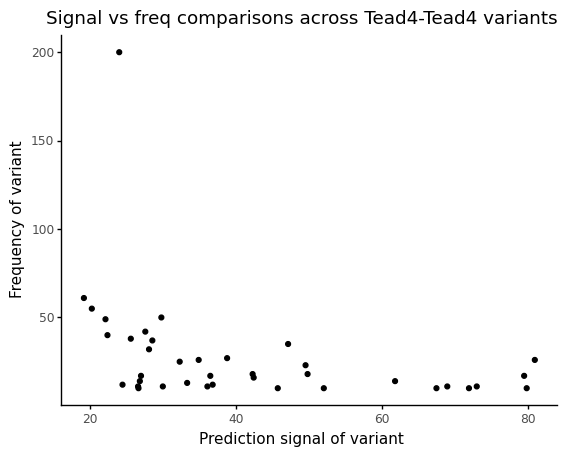

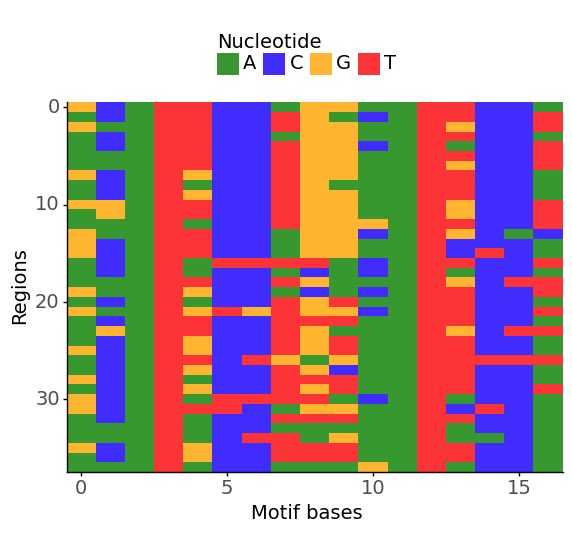

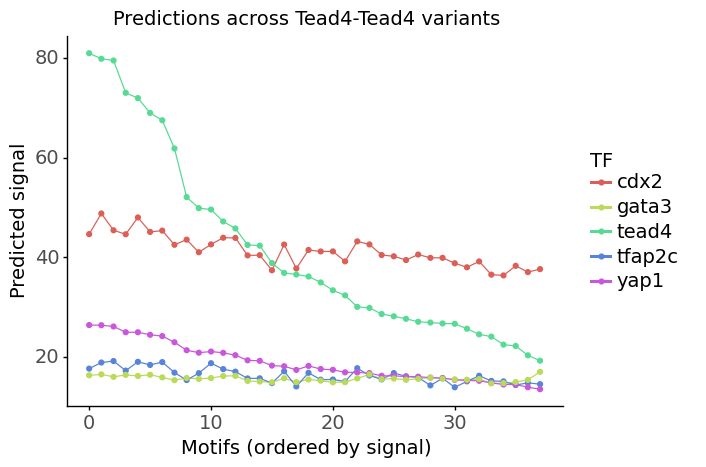

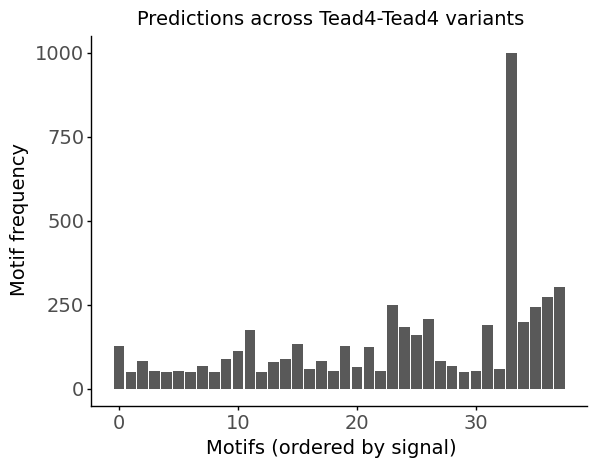

In [15]:
tead4tead4_ps_df = create_motif_aff_plots('Tead4-Tead4', 'tead4')       

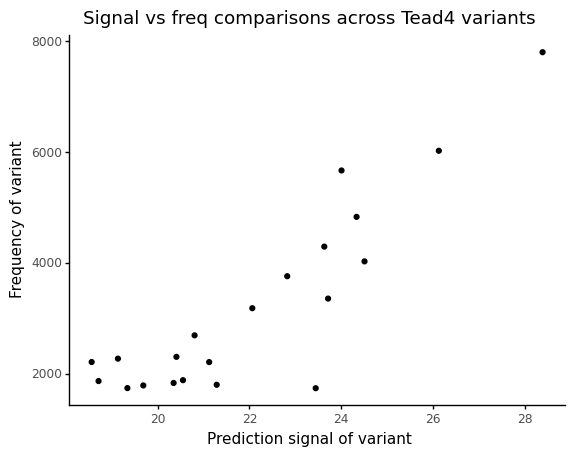

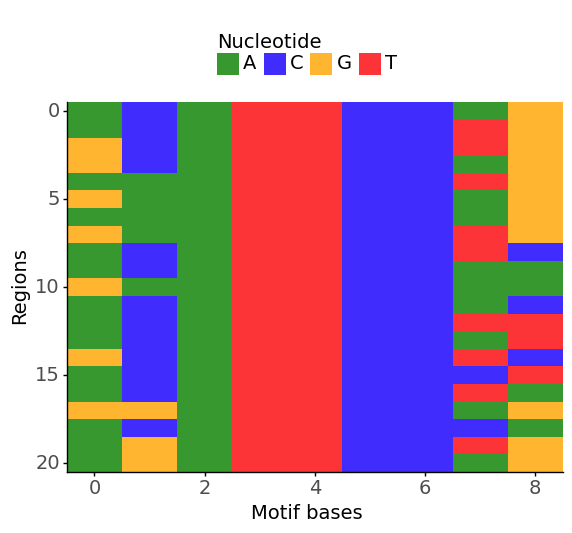

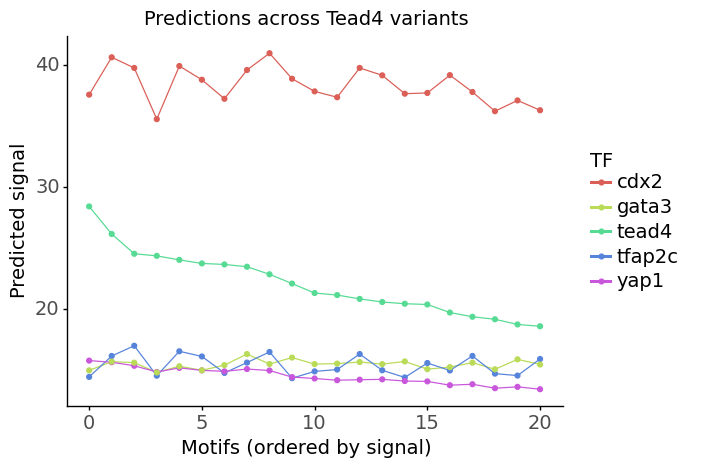

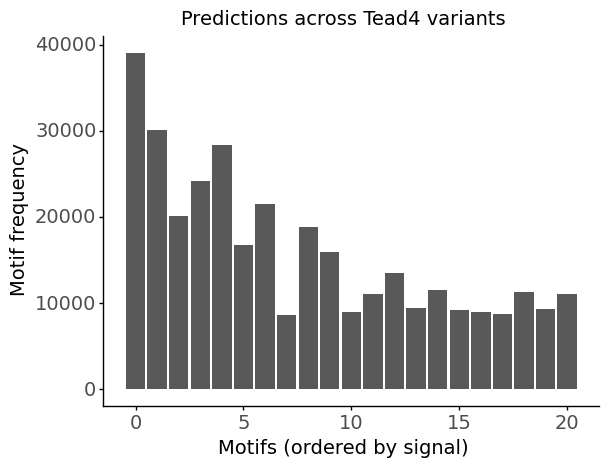

In [16]:
tead4_ps_df = create_motif_aff_plots('Tead4', 'tead4')       

# Save sequence information

In [17]:
all_ps_df = pd.concat([tead4tead4_ps_df, tead4_ps_df])
all_ps_df.to_csv(f'csv/tead4_tdbl_tsc_motif_affinity_predictions_test.csv', index = False)